# Navigation Docs

This notebook contains documentation for the [Navigation](https://github.com/UBCAgroBot/Navigation) repository. Follow the steps in the [README](../README.md) to install the dependencies and run the notebook.

In [1]:
import cv2 as cv
import numpy as np
import sys
from matplotlib import pyplot as plt
from IPython.display import Image
from pathlib import Path

In [2]:
# read image
img = cv.imread('./images/crop.jpg')
if img is None:
    sys.exit("Could not read the image. Make sure ./images/crop.png exists")

# Convert image from BGR to RGB since OpenCV uses BGR format and we want to display the image in RGB format
# This only needs to be done when plotting using matplotlib
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

h, w, _ = img.shape

# make sure that the output directory exists
Path("./images/output/").mkdir(parents=True, exist_ok=True)

# helper function to display and save image using matplotlib
# this is for displaying images in Jupyter Notebooks. Normally, you would use cv.imshow("window name", img) to display images.
def display(second_caption, second_img, first_caption=None, first_img=None, cmap=None, save=True):
    plt.figure(figsize=(15, 15))
    plt.subplot(121)
    if first_img is not None:
        plt.imshow(first_img, cmap=cmap)
        plt.title(first_caption)
    else:
        plt.imshow(img)
        plt.title('original image')
    plt.subplot(122)
    plt.imshow(second_img, cmap=cmap)
    plt.title(f'modified image: {second_caption}')
    if save:
        plt.savefig(f'./images/output/{second_caption}.jpg', dpi=600, bbox_inches='tight')
    plt.show()

# Preprocessing Images

### Creating a Mask

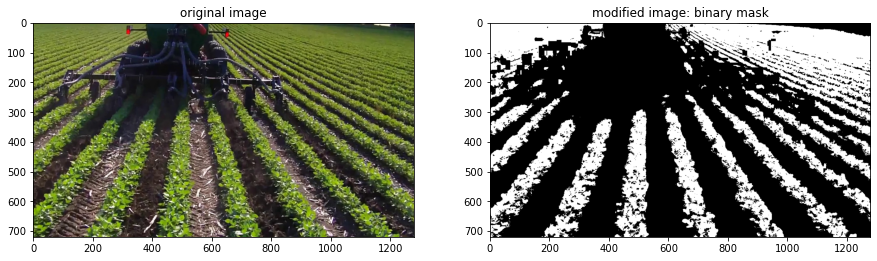

In [3]:
# Convert to hsv format to allow for easier colour filtering
hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

# lower and upper bounds for green color in the HSV color space
low = np.array([35, 80, 80])
high = np.array([80, 255, 255])

# Filter image and allow only shades of green to pass
binary_mask = cv.inRange(hsv, low, high)

# convert to RGB format to display using matplotlib
binary_mask_display = cv.cvtColor(src=binary_mask, code=cv.COLOR_BGR2RGB)
display('binary mask', binary_mask_display)

### Combining mask and original image

We can combine the mask and the original image by only showing the pixels where the mask is white using a bitwise and operation.

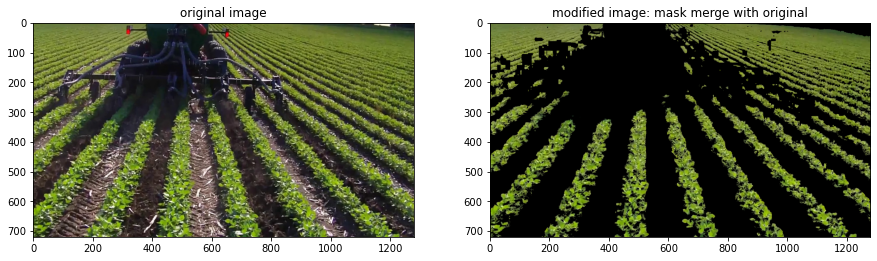

In [4]:
# bitwise and the original image with the binary mask
merged = cv.bitwise_and(img, img, mask=binary_mask)
display('mask merge with original', merged)

## Image Blurring (Image Smoothing)

### Gaussian Blurring

Gaussing Blurring is a common blurring method, it is available as an in-built function in OpenCV.

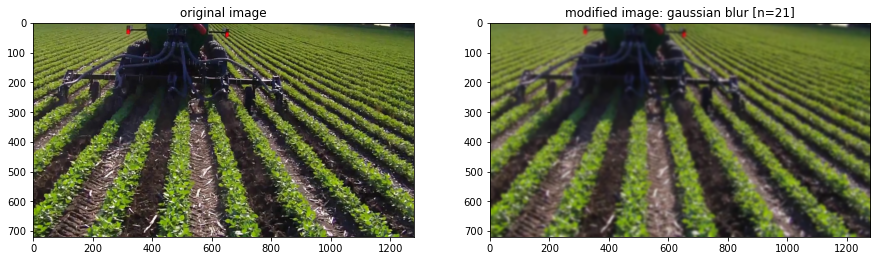

In [5]:
n = 21 # kernel size, must be positive and odd. Increasing n increases the blurriness
img_gaussian = cv.GaussianBlur(img,(n, n), 0)
display(f'gaussian blur [n={n}]', img_gaussian)

See filter2D section below to understand how Gaussian Blurring works.

### Median Blurring

Median blurring is a blurring method effective in removing noise from an image.

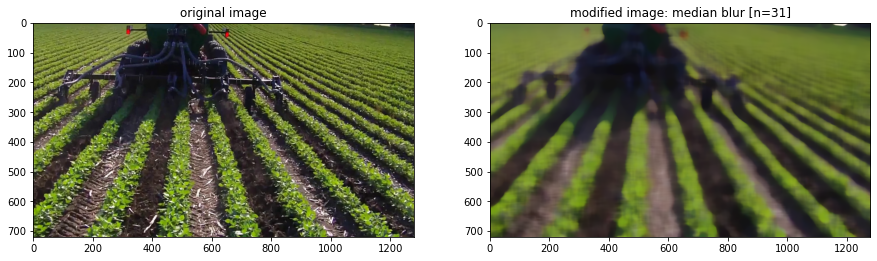

In [6]:
n = 31 # aperture linear size, must be positive and odd, Increasing n increases the blurriness
img_median = cv.medianBlur(img, n) 
display(f'median blur [n={n}]', img_median) 

## Combining Blurring and Masking

We have looked at how masking and blurring work individually. We can combine them to create a more robust mask by blurring the image first and then masking the image.

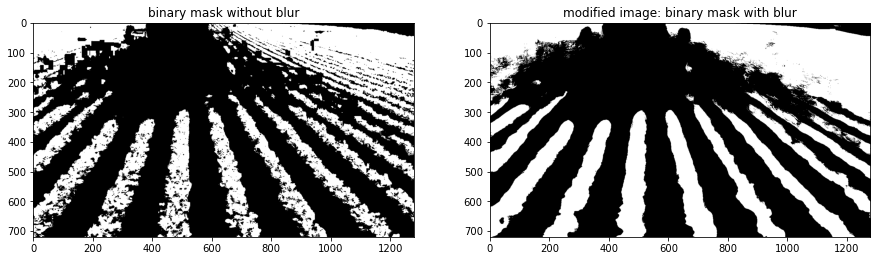

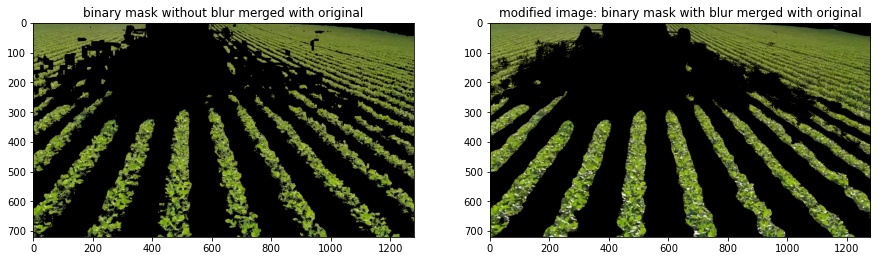

In [7]:
# Convert to hsv format to allow for easier colour filtering
hsv_blurred = cv.cvtColor(img_median, cv.COLOR_RGB2HSV)

# Filter image and allow only shades of green to pass
binary_mask_blurred = cv.inRange(hsv_blurred, low, high)

# convert to RGB format to display using matplotlib
binary_mask_blurred_display = cv.cvtColor(src=binary_mask_blurred, code=cv.COLOR_BGR2RGB)
display('binary mask with blur', binary_mask_blurred_display, 'binary mask without blur', binary_mask_display)

# bitwise and the original image with the blurred binary mask
merged_blurred = cv.bitwise_and(img, img, mask=binary_mask_blurred)
display('binary mask with blur merged with original', merged_blurred, 'binary mask without blur merged with original', merged)

## filter2D (Convolution)

This section is about OpenCV's filter2D function. Read [this](https://www.geeksforgeeks.org/python-opencv-filter2d-function) and [this](https://sbme-tutorials.github.io/2018/cv/notes/4_week4.html) before continuing.

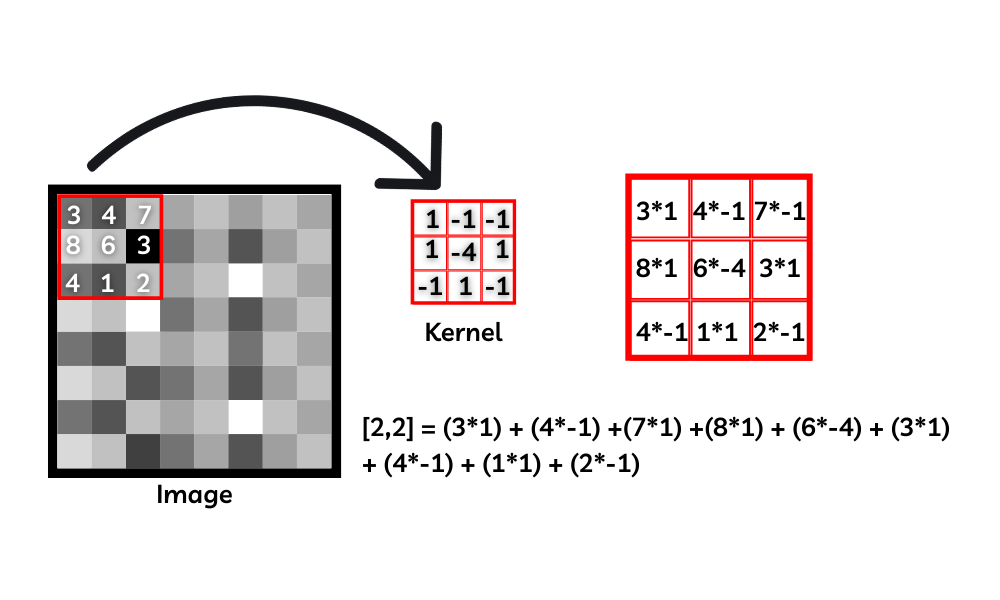

In [8]:
Image(filename='images/convolution_example.png', width=500)

In the example above, cell `[2,2]` which has the original value of 6 is replaced by the sum of the values of the cells in the kernel multilplied by the corresponding weights. This process is done for each pixel. In the example above, `n = 3`.

### Box Blur (Averaging)

Box blur involves setting the value of each pixel to the average of the values of the pixels around it. Increasing size of the kernel `n`,  increases the blur.

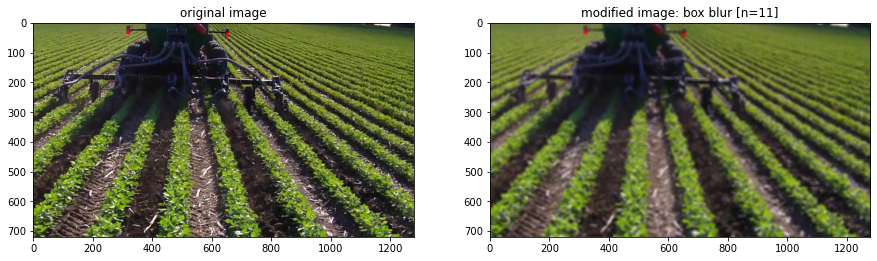

In [9]:
n =  11  # kernel size
d = n * n  # 1/d is the value of each pixel in the kernel.

# kernel
kernel = np.ones((n, n), np.float32) / d

img_averaging = cv.filter2D(img, -1, kernel)

display(f'box blur [n={n}]', img_averaging)

### Gaussian Blur

Earlier, we looked at the in-built function `cv.GaussianBlur()`, which essentially performs a convolution of the image with a Gaussian kernel. The image below is a Gaussian kernel of size `n = 5`. Essentially, it gives more weight to pixels near the center of the kernel.

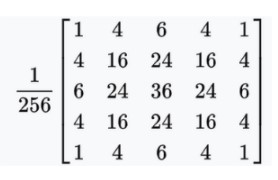

In [10]:
Image(filename='images/gaussian_kernel.jpg')

## Edge detection

There are multiple methods to detect edges in an image. We'll go over a few built-in methods available in OpenCV as well as take a look at how filter2D can be used to detect edges using different kernels.

### Canny Edge Detection

Canny edge detection is a method to detect edges in an image. We can pass in a blurred binary mask for better results

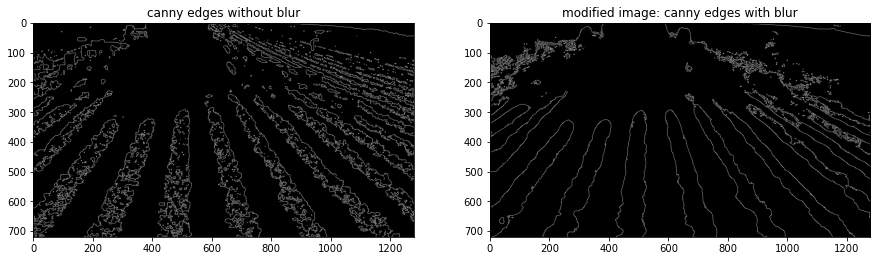

In [11]:
# without blur
v = np.median(binary_mask)
threshold1 = int(max(0, (1.0 - 0.33) * v))
threshold2 = int(min(255, (1.0 + 0.33) * v))

edges = cv.Canny(binary_mask, threshold1, threshold2)

# with blur
v_blurred = np.median(binary_mask_blurred)
threshold1_blurred = int(max(0, (1.0 - 0.33) * v_blurred))
threshold2_blurred = int(min(255, (1.0 + 0.33) * v_blurred))

edges_blurred = cv.Canny(binary_mask_blurred, threshold1_blurred, threshold2_blurred)

display('canny edges with blur', edges_blurred,'canny edges without blur', edges, cmap='gray')

### Sobel Operator

Below is an example of Sobel Operator. It is another inbuilt function in OpenCV and it combined with GaussianBlur to smoothen the image.

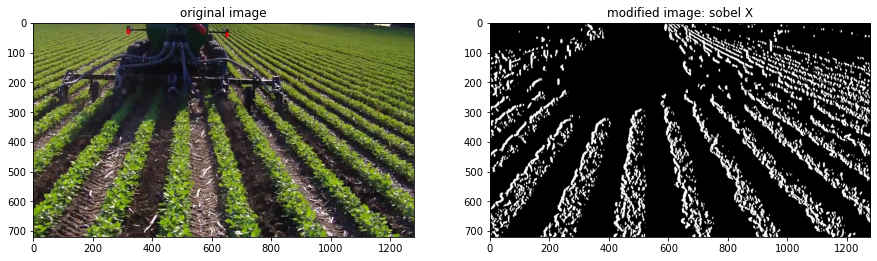

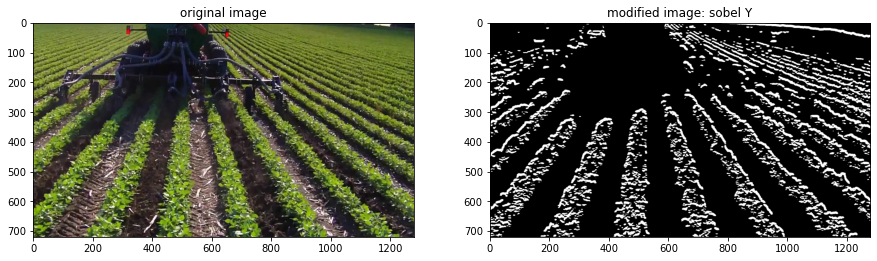

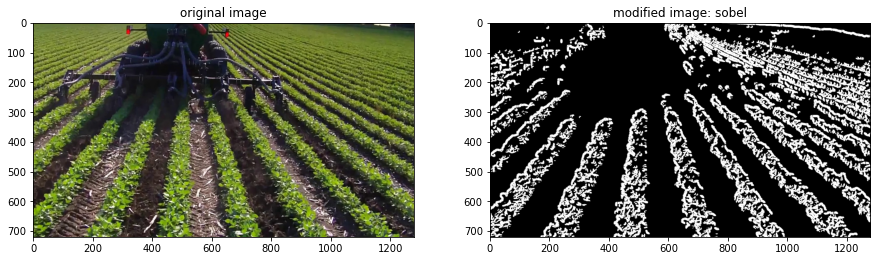

In [12]:
img_gaussian = cv.GaussianBlur(binary_mask, (5, 5), 0)

img_sobelx = cv.Sobel(img_gaussian, cv.CV_8U, 1, 0, ksize=5)
img_sobely = cv.Sobel(img_gaussian, cv.CV_8U, 0, 1, ksize=5)
img_sobel = img_sobelx + img_sobely

display("sobel X", img_sobelx, cmap='gray')
display("sobel Y", img_sobely, cmap='gray')
display("sobel", img_sobel, cmap='gray')

### Prewitt Operator

Prewitt Operator is another edge detection method, but instead of using an inbuilt function, it uses filter2D and a kernel to convolve the image.

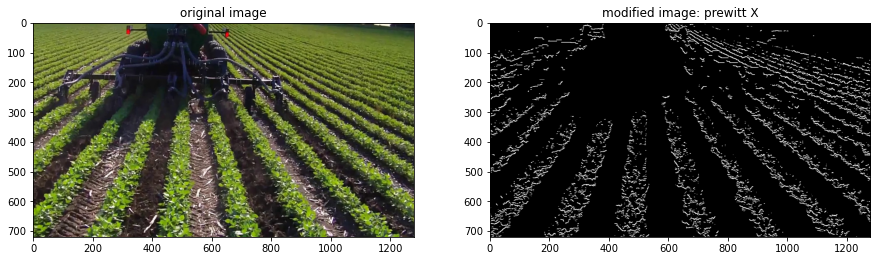

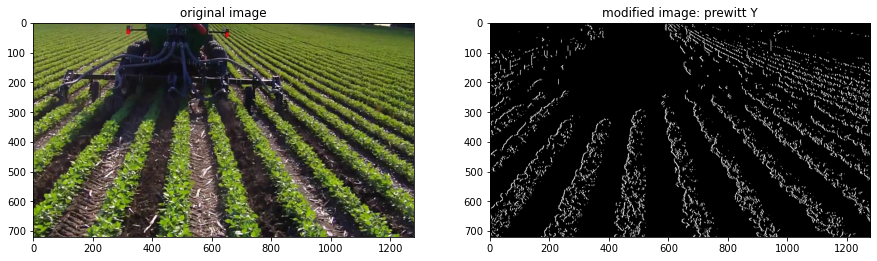

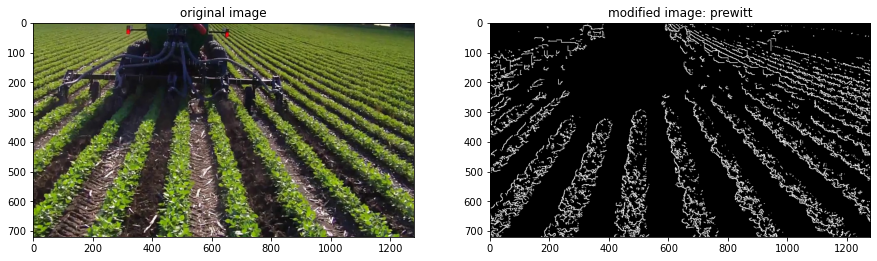

In [13]:
kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
img_prewittx = cv.filter2D(binary_mask, -1, kernelx)
img_prewitty = cv.filter2D(binary_mask, -1, kernely)
img_prewitt = img_prewittx + img_prewitty

display("prewitt X", img_prewittx, cmap='gray')
display("prewitt Y", img_prewitty, cmap='gray')
display("prewitt", img_prewitt, cmap='gray')